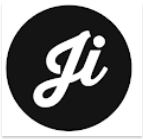

<center>
    <b>Redes Neuronales</b><br>
    <b>Elaborado por: Juan Isaula, Lic</b>
<br><br>
<b>Objetivo:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">
Inflation forecasts Honduras</div>
</center>
<i>Creado:     2022-Septiembre
<br>
Actualizado: 2020-Noviembre</i>


## Cargar paquetes necesarios

In [ ]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
 
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import seaborn as sns
from matplotlib.ticker import FuncFormatter

<ipython-input-2-6242d2752a60>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Cargamos la data a utilizar, en este caso la inflación de Honduras Comprendida en los periodos 1992 a 2022 de manera mensual. 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Inflacion_Honduras.csv to Inflacion_Honduras.csv


Revisamos nuestros datos, en este caso apareceran dos campos, el primer campo corresponde a las fechas de manera mensual y el segundo corresponde al porcentaje de inflacion en dicho mes del año correspondiente.

In [ ]:
inflacion_Honduras = pd.read_csv("Inflacion_Honduras.csv", parse_dates = True)
inflacion_Honduras.head()

,Date,Inflacion
0,1992-01-01,16.53
1,1992-02-01,14.09
2,1992-03-01,12.83
3,1992-04-01,10.37
4,1992-05-01,9.52


Gráfico sobre serie temporal de Inflacion de Honduras.

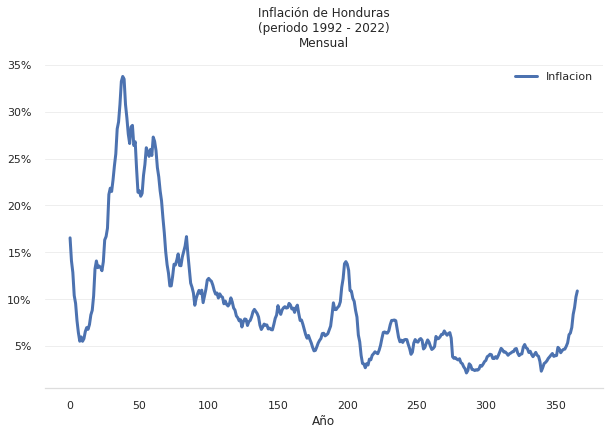

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

sns.set_context("talk")
sns.set_style("ticks")
sns.set(style="white", rc={"lines.linewidth": 3})

fig, ax = plt.subplots(sharey = True,figsize = (10,6))

g1 = sns.lineplot(data= inflacion_Honduras,
                  color='red', 
                  ax = ax)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/100))) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel('Año')
ax.set_title('Inflación de Honduras\n'
'(periodo 1992 - 2022)\n'
"Mensual", pad=15)

plt.show()

Normalizamos la data

In [ ]:
inflacion = inflacion_Honduras[["Inflacion"]]
inflacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflacion  367 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [ ]:
scala = MinMaxScaler(feature_range = (-1, 1))
inflacion["Inflacion"] = scala.fit_transform(inflacion["Inflacion"].values.reshape(-1,1))

<ipython-input-7-162c6fd5074c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(inflacion, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (278, 19, 1)
y_train.shape =  (278, 1)
x_test.shape =  (69, 19, 1)
y_test.shape =  (69, 1)


In [ ]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 24
num_layers = 2
output_dim = 1
num_epochs = 420

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Tiempo de entrenamiento: {}".format(training_time))

Epoch  0 MSE:  0.4594612419605255
Epoch  1 MSE:  0.33287107944488525
Epoch  2 MSE:  0.23879697918891907
Epoch  3 MSE:  0.17842134833335876
Epoch  4 MSE:  0.18476589024066925
Epoch  5 MSE:  0.19866041839122772
Epoch  6 MSE:  0.1717165857553482
Epoch  7 MSE:  0.14771386981010437
Epoch  8 MSE:  0.1377035528421402
Epoch  9 MSE:  0.1326906383037567
Epoch  10 MSE:  0.12350358068943024
Epoch  11 MSE:  0.10557852685451508
Epoch  12 MSE:  0.08176952600479126
Epoch  13 MSE:  0.06951406598091125
Epoch  14 MSE:  0.07372501492500305
Epoch  15 MSE:  0.05702085793018341
Epoch  16 MSE:  0.04213075712323189
Epoch  17 MSE:  0.047313373535871506
Epoch  18 MSE:  0.05017794296145439
Epoch  19 MSE:  0.041249729692935944
Epoch  20 MSE:  0.03609352558851242
Epoch  21 MSE:  0.039179082959890366
Epoch  22 MSE:  0.03860695660114288
Epoch  23 MSE:  0.032235126942396164
Epoch  24 MSE:  0.027056504040956497
Epoch  25 MSE:  0.02593148872256279
Epoch  26 MSE:  0.02640788070857525
Epoch  27 MSE:  0.025768090039491653


In [ ]:
predict = pd.DataFrame(scala.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scala.inverse_transform(y_train_lstm.detach().numpy()))

In [ ]:
comparativa = pd.DataFrame()
comparativa['Orignal']    = original
comparativa['Predicción'] = predict
comparativa

,Orignal,Predicción
0,14.060000,14.321944
1,13.339999,14.495499
2,13.520000,13.248434
3,13.370001,13.469060
4,13.020000,13.353335
...,...,...
273,2.360000,2.484146
274,2.450000,2.446752
275,2.400000,2.598311
276,2.510000,2.495978


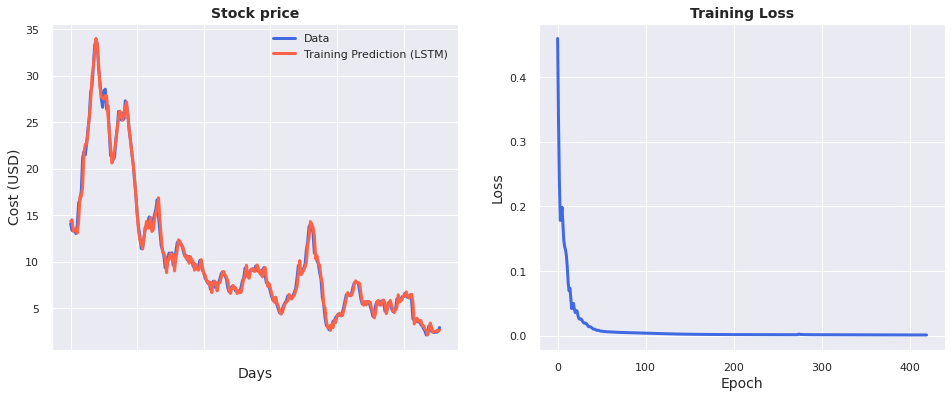

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)



In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# Hacer Predicciones
y_test_pred = model(x_test)

# Invertir Predicciones
y_train_pred = scala.inverse_transform(y_train_pred.detach().numpy())
y_train = scala.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scala.inverse_transform(y_test_pred.detach().numpy())
y_test = scala.inverse_transform(y_test_lstm.detach().numpy())

# calcular la raíz del error cuadrático medio
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.59 RMSE
Test Score: 0.36 RMSE


In [ ]:
# predicciones de cambios de entrenamiento para trazar
trainPredictPlot = np.empty_like(inflacion)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# predicciones de prueba de cambio para trazar
testPredictPlot = np.empty_like(inflacion)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(inflacion)-1, :] = y_test_pred

original = scala.inverse_transform(inflacion['Inflacion'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        title_text = '',
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Tasa de Inflación',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

## Predicciones Futuras con LSTM

## Modelo GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3621300160884857
Epoch  1 MSE:  0.2067054957151413
Epoch  2 MSE:  0.14925184845924377
Epoch  3 MSE:  0.1668137013912201
Epoch  4 MSE:  0.1473458856344223
Epoch  5 MSE:  0.10623873025178909
Epoch  6 MSE:  0.07965153455734253
Epoch  7 MSE:  0.0674208402633667
Epoch  8 MSE:  0.05433754250407219
Epoch  9 MSE:  0.0327574722468853
Epoch  10 MSE:  0.0158851258456707
Epoch  11 MSE:  0.028297578915953636
Epoch  12 MSE:  0.03900274261832237
Epoch  13 MSE:  0.028455328196287155
Epoch  14 MSE:  0.024148546159267426
Epoch  15 MSE:  0.02467283420264721
Epoch  16 MSE:  0.01988799311220646
Epoch  17 MSE:  0.012671507894992828
Epoch  18 MSE:  0.009328505024313927
Epoch  19 MSE:  0.011323508806526661
Epoch  20 MSE:  0.014487777836620808
Epoch  21 MSE:  0.014842732809484005
Epoch  22 MSE:  0.013009863905608654
Epoch  23 MSE:  0.011646956205368042
Epoch  24 MSE:  0.011613267473876476
Epoch  25 MSE:  0.011689594946801662
Epoch  26 MSE:  0.010562603361904621
Epoch  27 MSE:  0.00833887234330

In [ ]:
predict = pd.DataFrame(scala.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scala.inverse_transform(y_train_gru.detach().numpy()))

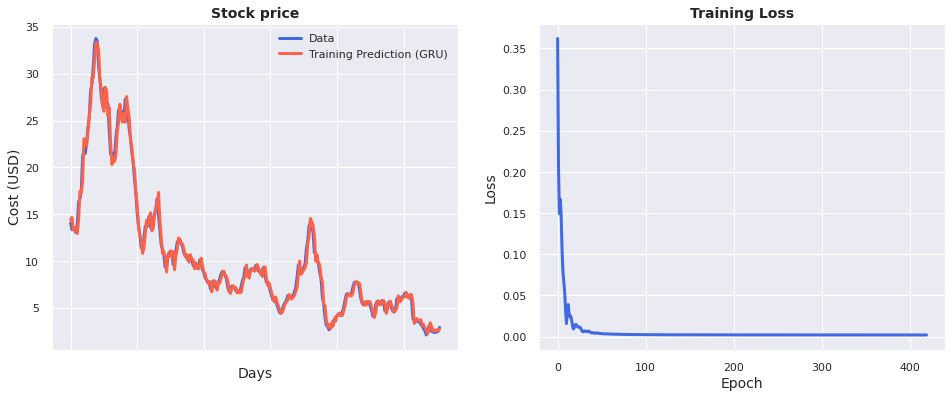

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scala.inverse_transform(y_train_pred.detach().numpy())
y_train = scala.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scala.inverse_transform(y_test_pred.detach().numpy())
y_test = scala.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 0.71 RMSE
Test Score: 0.36 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(inflacion)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(inflacion)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(inflacion)-1, :] = y_test_pred

original = scala.inverse_transform(inflacion['Inflacion'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

## Comparativa de resultados

In [ ]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,0.605201,0.712170
Test RMSE,0.356634,0.363438
Train Time,11.294386,9.890790
